# Predictive Maintenance: Predicting the Remaining Useful Life using Random Forest Regression

This project was develop as part of the course 'Projektstudium' at OTH Regensburg.

The aim of this project is to apply Random Forest Regression in order to predict the Remaining Useful Life of machines.

The used dataset is available under the link:
https://www.kaggle.com/datasets/arnabbiswas1/microsoft-azure-predictive-maintenance?select=PdM_errors.csv

## Loading data,  pre-processing and exploratory data analysis
In this section, the following preperation-steps are conducted:
- Loading data.
- Data pre-processing in order to ensure high data quality.
- Exploratory data analysis in ordert to gain an understanding of the data.

In [1]:
import pandas as pd

In [2]:
# Loading the datasets
df_errors = pd.read_csv('PdM_errors.csv')
df_failures = pd.read_csv('PdM_failures.csv')
df_machines = pd.read_csv('PdM_machines.csv')
df_sensors = pd.read_csv('PdM_telemetry.csv')

To begin with, the sensor-data is examined in detail

In [3]:
# Outputting a sample of the sensor-data
df_sensors.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [4]:
# Checking the minimum and maximum datetime of the sensor-readings
print('Minimum datetime:', df_sensors['datetime'].min())
print('Maximum datetime:', df_sensors['datetime'].max())

Minimum datetime: 2015-01-01 06:00:00
Maximum datetime: 2016-01-01 06:00:00


The sensor-data was collected for 2015, where the sensor-readings are logged on an hourly basis.

In the next step, the machine-data will be looked at.

In [5]:
# Outputting a sample of the machine-data
df_machines.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [6]:
# Outputting relevant metrics for the machines
print('Number of different machines:', df_machines['machineID'].nunique())
print('Number of different machine models:', df_machines['model'].nunique())
print('Average age of the maschines:', df_machines['age'].mean(), 'years')
print('Minimum age of the maschines:', df_machines['age'].min(), 'years')
print('Maximum age of the maschines:', df_machines['age'].max(), 'years')

Number of different machines: 100
Number of different machine models: 4
Average age of the maschines: 11.33 years
Minimum age of the maschines: 0 years
Maximum age of the maschines: 20 years


In [7]:
# Analyzing the unique machineIDs
df_machines['machineID'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

In [8]:
# Analyzing the different machine models
df_machine_models = df_machines.groupby('model').agg(
    machineID_count=('machineID', 'count'),
    avg_age=('age', 'mean')
)

df_machine_models.head()

,machineID_count,avg_age
model,,
model1,16,12.250000
model2,17,12.764706
model3,35,12.028571
model4,32,9.343750


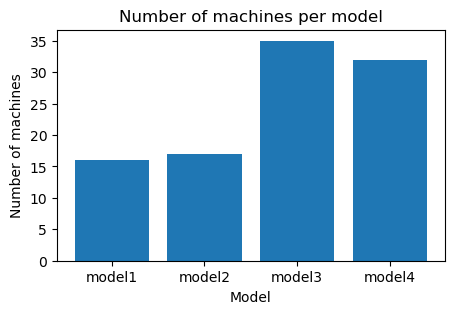

In [26]:
# Visualizing the number of machines per model

import matplotlib.pyplot as plt

figure, axis1 = plt.subplots(figsize=(5,3))

# Creating a bar chart for the number of machines per model on the primary y-axis
axis1.bar(df_machine_models.index, df_machine_models['machineID_count'])
axis1.set_xlabel('Model')
axis1.set_ylabel('Number of machines')
axis1.set_title('Number of machines per model')

plt.show()

In total, there are 100 different machines and four different machine models. The machines have an average age of 11.33 years, with ages ranging from less than one year to twenty years.

This information is highly relevant for predictive maintainence, since different models have different deterioration profiles.
On top of that, older machines are more livulnerable  malfunctions than newer machines.

Originally, there is a clear distinction between errors and failures within the used dataset.
An error is malfunction, that does not lead to a machine shutdown.
A failure, on the other hand, is a malfunction, where a component has broken down and needed replacement, resulting in a standstill.

Source: https://www.kaggle.com/datasets/arnabbiswas1/microsoft-azure-predictive-maintenance?select=PdM_errors.csv

Within the scope of this project, there will be no explicit differentiation between failure and error.
Instead failure and errors will collectively be regarded as malfunctions.

In [11]:
# Combining the failures and errors into a single dataframe containing all machine malfunctions
df_malfunction  = pd.concat([df_errors, df_failures], axis=0, ignore_index=True)

# Selecting only the columns 'datetime' and 'machineID'
df_malfunction = df_malfunction[['datetime', 'machineID']]

# Sorting the dataframe by 'machineID' and 'datetime'
df_malfunction = df_malfunction.sort_values(by=['machineID','datetime'])

In [12]:
# Outputting a sample of the 
df_malfunction.sample(5)

,datetime,machineID
3634,2015-04-11 23:00:00,94
366,2015-04-08 02:00:00,11
4498,2015-07-12 06:00:00,80
670,2015-03-25 05:00:00,18
3572,2015-06-14 09:00:00,92


In [13]:
# Checking and dropping duplicate rows
print('Number of duplicate rows:', df_malfunction.duplicated().sum())
df_malfunction = df_malfunction.drop_duplicates()

Number of duplicate rows: 348


## Calculating the Remaining Useful Life (RUL)
So far, the RUL does not exist in the given dataset.
However, since the goal is to predict the RUL, the RUL must first be calculated in order to train and evaluate the random forest model later on.

Based on (Jamshidi et al., 2025, S.6), the RUL is defined as "the time left before a failure occurs". Where $t_f$ is the time of failure and $t_c$ is the current time, the RUL can be calculated using the following formila.

$$
RUL = t_f - t_c
$$

As explained earlier, in this project, there will be no explicit distinction between failure and error, therfore $t_f$ represents the time of any malfunction.


### Combining the sensor-data with the malfucntion- and machine-data

In order to calculate the Remaining Useful Life, the sensor-data and malfunction-data need to be combined.

For this, the sensor-data and malfunction-data will be combined by merging each row of the sensor-data with the next future malfunction of the specific machine.

In [14]:
# Merging the sensor-data and malfunction-data

# Renaming the 'datetime' column for the malfunctions in order to avoid name-conflics while merging
df_malfunction = df_malfunction.rename(columns={'datetime': 'malfunction_datetime'})

# Converting the 'datetime' columns into datetime-objects
df_sensors['datetime'] = pd.to_datetime(df_sensors['datetime'])
df_malfunction['malfunction_datetime'] = pd.to_datetime(df_malfunction['malfunction_datetime'])

# Sorting both dataframes by 'datetime'
df_sensors = df_sensors.sort_values(['datetime']).reset_index(drop=True)
df_malfunction = df_malfunction.sort_values(['malfunction_datetime']).reset_index(drop=True)

# Merging the sensor and malfunction data by matching each sensor-row with the next (future) malfunction 
df_sensors_malfunctions = pd.merge_asof(
    df_sensors, df_malfunction,
    left_on='datetime', right_on='malfunction_datetime',
    by='machineID',
    direction='forward'
)

# Calculating the RUL in hours
df_sensors_malfunctions['RUL'] = (df_sensors_malfunctions['malfunction_datetime'] - df_sensors_malfunctions['datetime']).dt.total_seconds() / 3600


In [15]:
# Since the RUL cannot be calculated for sensor rows that happended after the last malfunctions, these rows have to be dropped
df_sensors_malfunctions = df_sensors_malfunctions.dropna(subset=['RUL'])

In [16]:
# Dropping the column 'malfunction_datetime', since it isn't needed anymore
df_rul = df_sensors_malfunctions.drop('malfunction_datetime', axis=1)

In [17]:
# Checking if the RUL column contains empty values
df_rul.info()

<class 'pandas.core.frame.DataFrame'>
Index: 853548 entries, 0 to 875960
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   datetime   853548 non-null  datetime64[ns]
 1   machineID  853548 non-null  int64         
 2   volt       853548 non-null  float64       
 3   rotate     853548 non-null  float64       
 4   pressure   853548 non-null  float64       
 5   vibration  853548 non-null  float64       
 6   RUL        853548 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 52.1 MB


In [18]:
# Outputting a few lines with the calculated RUL
df_rul.head()

,datetime,machineID,volt,rotate,pressure,vibration,RUL
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,49.0
1,2015-01-01 06:00:00,53,183.084582,420.980061,109.235805,45.737760,217.0
2,2015-01-01 06:00:00,99,168.596133,384.747105,110.921131,41.944692,21.0
3,2015-01-01 06:00:00,12,171.404215,576.923563,97.145400,47.725909,120.0
4,2015-01-01 06:00:00,6,136.878588,492.088420,149.003582,22.973289,318.0


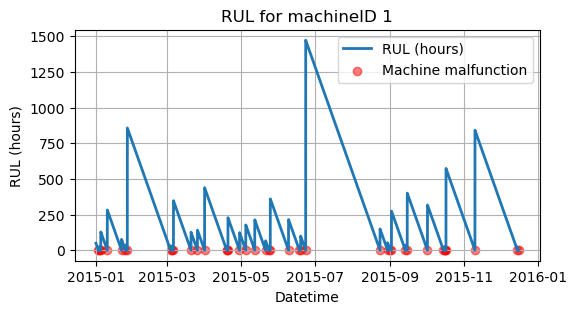

In [29]:
# Visualizing the RUL for machineID 1

import matplotlib.pyplot as plt

# Selecting the data for machine 1
df_machine_1 = df_rul[df_rul['machineID'] == 1]

# Definint the x and y values
x_values = df_machine_1['RUL']
y_values = df_machine_1['datetime']

# Defining the size of the chart
plt.figure(figsize=(6,3))

# Plotting a line chart showing the RUL over time
plt.plot(y_values, x_values, label='RUL (hours)', linestyle='-', linewidth=2)

# Plotting the machine stops as points
df_malfunction_machine_1 = pd.concat([df_errors, df_failures], axis=0, ignore_index=True)
df_malfunction_machine_1 = df_malfunction_machine_1[df_malfunction_machine_1['machineID'] == 1]
df_malfunction_machine_1['RUL'] = 0
plt.scatter(df_malfunction_machine_1['datetime'], df_malfunction_machine_1['RUL'], color='red', alpha=0.5, label='Machine malfunction')


plt.xlabel('Datetime')
plt.ylabel('RUL (hours)')
plt.title('RUL for machineID 1')
plt.legend()
plt.grid(True)
plt.show()

## Developing the Random Forest Regressor
In this section, the Random Forest Regressor will be developed using scikit-learn to predict the Remaining Useful Life.

The key steps involved in this process are:
- Feature Engineering: The relevant features will be chosen and additional features extracted from the raw sensor data.
- Splitting the dataset: The dataset will be divided into a training set for model learning and a testing set for model evaluation.
- Training the Random Forest Regressor: The model will be trained based on the training set.
- Testing and Evaluation: The trained model will be tested on the testing set and evaluated based on various metrics.

### Feature Engineering
At first the relevant input features for training the Random Forest Regressor will be defined.

In [294]:
# Outputting an overview of the rul-dataset
df_rul.sample(5)

,datetime,machineID,volt,rotate,pressure,vibration,RUL,model,age,volt_lag_1,...,pressure_moving_average_600,pressure_rolling_standard_deviation_10,pressure_rolling_standard_deviation_80,pressure_rolling_standard_deviation_600,vibration_moving_average_10,vibration_moving_average_80,vibration_moving_average_600,vibration_rolling_standard_deviation_10,vibration_rolling_standard_deviation_80,vibration_rolling_standard_deviation_600
221117,2015-11-24 16:00:00,26,168.158894,507.781098,88.808405,29.549846,254.0,3,3,169.042568,...,99.689894,6.818398,8.189127,9.763532,38.978614,39.186104,40.014001,5.255245,4.843738,4.939645
803552,2015-03-01 13:00:00,95,175.821371,368.356207,114.747692,43.980024,55.0,2,18,171.581994,...,99.804541,14.037791,11.404347,10.308057,40.844341,40.401831,40.658216,3.656706,4.950737,5.577619
21578,2015-07-08 06:00:00,3,195.060984,430.247400,94.331057,45.244063,39.0,3,8,141.741151,...,102.402706,7.383072,8.116135,11.754222,41.265006,40.425679,40.287427,4.541097,5.162388,4.917115
778782,2015-03-25 20:00:00,92,167.000336,391.504708,107.460282,39.555417,31.0,1,2,181.400289,...,102.087238,7.453180,9.833364,11.769282,38.965211,40.823776,40.220135,6.113447,5.198999,5.106043
490006,2015-05-30 22:00:00,58,174.789991,248.127277,98.611574,39.981493,8.0,1,5,186.644266,...,99.726213,10.444399,9.561431,10.178601,40.136980,40.268790,40.061506,6.946267,4.939050,4.866298


The model and age of a machine contain valuable are valuable information required for achieving accurate predictions.
Therefore these informations need to be added from the machine-data.
The Random Forest Regressor only works with numerical input, therefore the machine model (which is text) must be transformed into numerical values.

In [286]:
# Adding the machine model and age
df_rul = df_rul.merge(df_machines, on='machineID', how='left')

In [287]:
# Transforming the column 'model' model from text (String) into numeric (int)
df_rul['model'] = df_rul['model'].replace({
    'model1': 1,
    'model2': 2,
    'model3': 3,
    'model4': 4
}).astype(int)

C:\Users\rapha\AppData\Local\Temp\ipykernel_10920\4054518210.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_rul['model'] = df_rul['model'].replace({


When using only raw sensor data, the prediction results are not reliable.
In order to capture short-term, mid-term and long-term trends within the data, additional features have be extracted from the raw data.
For this purpose, lag features, rolling statistics and cumulative features will be created.

In [290]:
# Creating lag features and rolling mean features and cumulative features for capturing trends in the sensor data
df_rul = df_rul.sort_values(['machineID', 'datetime']).reset_index(drop=True)

# Defining the columns to create lag features for
sensor_columns = ['volt', 'rotate', 'pressure', 'vibration']

# Creating the lag features for these columns
for column in sensor_columns:
    df_rul[f'{column}_lag_1'] = df_rul.groupby('machineID')[column].shift(1)
    df_rul[f'{column}_lag_2'] = df_rul.groupby('machineID')[column].shift(2)

In [ ]:
# Creating rollings statistics for each of the sensors
for column in sensor_columns:
    # In order to account for short term and long term trends, several moving averages are calculated
    df_rul[f'{column}_moving_average_10'] = df_rul.groupby('machineID')[column].rolling(window=10).mean().reset_index(drop=True)  
    df_rul[f'{column}_moving_average_80'] = df_rul.groupby('machineID')[column].rolling(window=80).mean().reset_index(drop=True)
    df_rul[f'{column}_moving_average_600'] = df_rul.groupby('machineID')[column].rolling(window=600).mean().reset_index(drop=True)
    df_rul[f'{column}_rolling_standard_deviation_10'] = df_rul.groupby('machineID')[column].rolling(window=10).std().reset_index(drop=True)
    df_rul[f'{column}_rolling_standard_deviation_80'] = df_rul.groupby('machineID')[column].rolling(window=80).std().reset_index(drop=True)
    df_rul[f'{column}_rolling_standard_deviation_600'] = df_rul.groupby('machineID')[column].rolling(window=600).std().reset_index(drop=True)

In [296]:
# Creating the cumulative features for each of the sensors
for column in sensor_columns:
    df_rul[f'{column}_cumulative_sum'] = df_rul.groupby('machineID')[column].cumsum()

In [ ]:
# Outputting an overview of the transformed rul-dataset
df_rul.sample(5)

In [298]:
# Identifying the number of columns in the transformed rul-dataset
df_rul.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 853548 entries, 0 to 853547
Data columns (total 45 columns):
 #   Column                                    Non-Null Count   Dtype         
---  ------                                    --------------   -----         
 0   datetime                                  853548 non-null  datetime64[ns]
 1   machineID                                 853548 non-null  int64         
 2   volt                                      853548 non-null  float64       
 3   rotate                                    853548 non-null  float64       
 4   pressure                                  853548 non-null  float64       
 5   vibration                                 853548 non-null  float64       
 6   RUL                                       853548 non-null  float64       
 7   model                                     853548 non-null  int64         
 8   age                                       853548 non-null  int64         
 9   volt_lag_1     

After Feature Engineering, the rul-dataset contains a total of 45 columns

Before the Random Forest Model can be trained, the input features and target feature (feature that will be predicted) have to be defined.

Since the Remaining Useful Life is the feature that is to be predicted, the RUL makes up the target feature. 

In [299]:
# Defining the Remaining Useful Life as target feature (y)
y = df_rul['RUL'] # The remaining useful life (RUL) is the target feature that has to be predicted

The Remaining Useful Life is the target feature and therefore has to be exclued from the input features.
On top of that, irrelevant columns that do not add valuable information have to be removed in order to not influence the results.

The column 'datetime' does not add any relevant information about a machines condition.
Therefore it is not needed for predicting the RUL and will be dropped.

Furthermore, the machineID itself is not an indicator of a machines condition.
Instead the relvant machine-information is given by the model and the age.
Consequently the machineID will also be dropped.

In [300]:
# Defining the input features (X) without 'RUL', 'datetime' and 'machineID'
X = df_rul.drop(['RUL', 'datetime', 'machineID'], axis=1)

### Creating, training and testing the Random Forest Regressor
In this section the Random Forest Regressor will be developed and evaluated. 

In [301]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [302]:
# Creating a training- and testing-dataset
X_train_set, X_test_set, y_train_set, y_test_set = train_test_split(X, y, test_size= 0.3, random_state=42)

# Creating a Random Forest regressor
random_forest = RandomForestRegressor(n_estimators=50, n_jobs=-1, max_depth=None, random_state = 13)

# 'Training' the Random Forest using the training-dataset
random_forest.fit(X_train_set, y_train_set)

RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=13)

In [303]:
# Applying the random forest regressor using the testing-dataset as input
y_predictions = random_forest.predict(X_test_set)

In [304]:
# Evaluating the random forest model

from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

r2 = r2_score(y_test_set, y_predictions)
mae = mean_absolute_error(y_test_set, y_predictions)
rmse = root_mean_squared_error(y_test_set, y_predictions)

print('Evaluation of the random forest model:')
print(f'R²: {r2:.4f}')
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')

Evaluation of the random forest model:
R²: 0.9822
MAE: 10.8554
RMSE: 29.7244


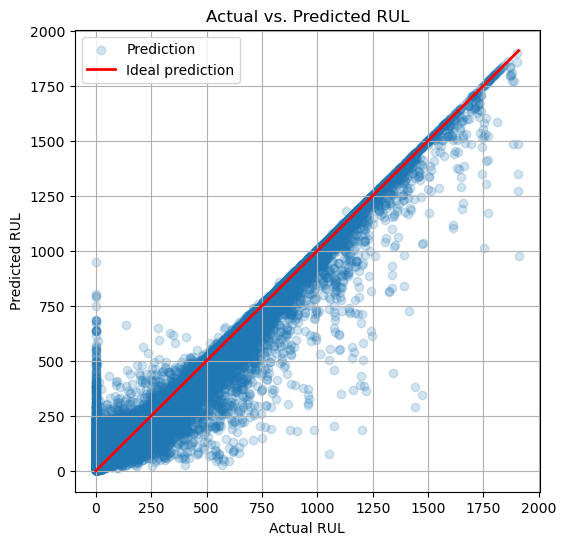

In [305]:
# Visualizing the difference between the actual RUL and the predicted RUL using a scatter plot

import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test_set, y_predictions, alpha=0.2, label='Prediction')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs. Predicted RUL')
plt.grid(True)
minimum = min(min(y_test_set), min(y_predictions))
maximum = max(max(y_test_set), max(y_predictions))
plt.plot([minimum, maximum], [minimum, maximum], linestyle='-', linewidth='2', label='Ideal prediction', color="red")
plt.legend()
plt.show()

## Citations
Jamshidi, A., Kim, D. & Arif, M. (2025). A survey of predictive maintenance methods: An analysis of prognostics via classification and regression. arXiv. Available under https://arxiv.org/abs/2506.20090 doi: 10.48550/ARXIV.2506.20090